In [1]:
# Warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import required lib
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud
sns.set_style('darkgrid')
plt.rcParams.update({'font.size': 15})

# Text Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from collections import Counter
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer

# 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout


In [3]:
review_df= pd.read_excel(r'Dataset/review_full_text_tripadvisor_raw.xlsx')
review_df.head()

,hotel_name,customer_name,title,full_content,rating,rating_new
0,Hotel des Arts Saigon Mgallery,Anh Tuấn L,Quá Tuyệt Vời Khi Ở Des Arts Sài Gòn,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệ...,bubble_50,5
1,Hotel des Arts Saigon Mgallery,TRƯƠNG BẰNG,Đáng đồng tiền!,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tậ...",bubble_50,5
2,Hotel des Arts Saigon Mgallery,Phong Thu Vu,huyền bí và ấn tượng,vài dòng note lại về #Mgalery huyền bí... khác...,bubble_50,5
3,Hotel des Arts Saigon Mgallery,monkeyminhvn,love decor and service,Mình rất thích ngắm mái vòm và những khung cửa...,bubble_50,5
4,Hotel des Arts Saigon Mgallery,Ngoc Dung P,"Dễ thương, ấm cúng",Ks không lớn lắm nhưng có lối trang trí ấm cún...,bubble_40,4


In [4]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82380 entries, 0 to 82379
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   hotel_name     82380 non-null  object
 1   customer_name  82380 non-null  object
 2   title          82378 non-null  object
 3   full_content   82380 non-null  object
 4   rating         82380 non-null  object
 5   rating_new     82380 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 3.8+ MB


In [5]:
review_df.columns

Index(['hotel_name', 'customer_name', 'title', 'full_content', 'rating',
       'rating_new'],
      dtype='object')

In [6]:
review_df[review_df['title'].isna()]

,hotel_name,customer_name,title,full_content,rating,rating_new
7661,Bui Vien 84 Hotel,99 Bui Vien Hotel (Boutique),NaN,Đến thành phố Hồ Chí Minh? Vẫn đang cân nhắc n...,bubble_50,5
15255,Hanoi La Storia Hotel,caleesiy,NaN,Khách sạn rất đẹp và rất sạch sẽ. Nhân viên rấ...,bubble_50,5


In [7]:
# fill NaN = empty string
review_df['title']= review_df['title'].fillna('')

# Filter the text and score

In [8]:
review_df['text']= review_df['title'] + review_df['full_content']

In [9]:
review_df= review_df[['hotel_name', 'text', 'rating_new']]
review_df.head(5)

,hotel_name,text,rating_new
0,Hotel des Arts Saigon Mgallery,Quá Tuyệt Vời Khi Ở Des Arts Sài Gòn#HôtelDesA...,5
1,Hotel des Arts Saigon Mgallery,"Đáng đồng tiền!Dịch vụ cao cấp, phong cách chu...",5
2,Hotel des Arts Saigon Mgallery,huyền bí và ấn tượng vài dòng note lại về #Mga...,5
3,Hotel des Arts Saigon Mgallery,love decor and serviceMình rất thích ngắm mái ...,5
4,Hotel des Arts Saigon Mgallery,"Dễ thương, ấm cúngKs không lớn lắm nhưng có lố...",4


In [10]:
review_df.shape

(82380, 3)

#### Check Duplicates

In [11]:
review_df.duplicated().value_counts()

False    78980
True      3400
Name: count, dtype: int64

In [12]:
review_df= review_df.drop_duplicates(subset= 'text')

#### Check non-exist comment

In [13]:
review_df['n_words']= review_df['text'].map(lambda text: len(text.split()))

In [14]:
review_df['n_words'].describe()

count    78968.000000
mean       106.806276
std         70.102394
min          3.000000
25%         60.000000
50%         84.000000
75%        137.000000
max       2154.000000
Name: n_words, dtype: float64

=> Don't have text NaN

#### View the classes

In [15]:
review_df['hotel_name'].value_counts()

hotel_name
Vinpearl Discovery 2 Phú Quốc                  944
Khu nghỉ dưỡng & sân golf Vinpearl Phú Quốc    619
VinOasis Phu Quoc                              527
Vinpearl Discovery 1 Nha Trang                 471
Vinpearl Resort & Spa Phu Quoc                 460
                                              ... 
Hoang Kim Long Hotel                             1
D.P. Hotel                                       1
Minh Chau Hotel                                  1
Thien Phu                                        1
Tommy Hotel                                      1
Name: count, Length: 7499, dtype: int64

In [16]:
review_df['rating_new'].value_counts()

rating_new
5    54577
4    12530
3     5153
1     4139
2     2569
Name: count, dtype: int64

In [17]:
review_df.groupby('rating_new').mean('n_words')

,n_words
rating_new,
1,165.557381
2,149.448424
3,128.536969
4,108.915243
5,97.807575


#### Some what equally separated

Text(0.5, 1.0, 'Number Ratings')

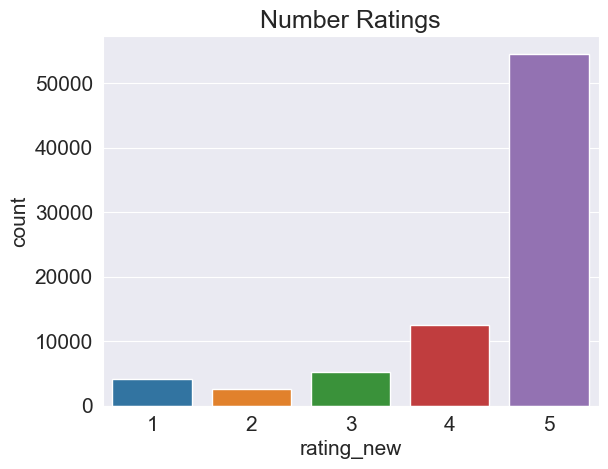

In [18]:
sns.countplot(review_df['rating_new'])
plt.xlabel('rating_new')
plt.title('Number Ratings')

# Pre-Processing

In [19]:
##LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()
#################
#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()
################
#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [20]:
def process_text(text, emoji_dict, teen_dict, wrong_lst):
    document = text.lower()
    document = document.replace("’",'')
    document = regex.sub(r'\.+', ".", document)
    new_sentence =''
    for sentence in sent_tokenize(document):
        # if not(sentence.isascii()):
        ###### CONVERT EMOJICON
        sentence = ''.join(emoji_dict[word]+' ' if word in emoji_dict else word for word in list(sentence))
        ###### CONVERT TEENCODE
        sentence = ' '.join(teen_dict[word] if word in teen_dict else word for word in sentence.split())
        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))
        ###### DEL wrong words   
        sentence = ' '.join('' if word in wrong_lst else word for word in sentence.split())
        new_sentence = new_sentence+ sentence + '. '                    
    document = new_sentence  
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [21]:
# Chuẩn hóa unicode tiếng việt
def loaddicchar():
    uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
    unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
 
# Đưa toàn bộ dữ liệu qua hàm này để chuẩn hóa lại
def covert_unicode(txt):
    dicchar = loaddicchar()
    return regex.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

In [22]:
# tạo elongated: vuiiii -> vui
from itertools import groupby
def elongated_remove(text):
    return ''.join(c for c, _ in groupby(text))

In [23]:
# có thể bổ sung thêm các từ: chẳng, chả...
def process_special_word(text):
    new_text = ''
    text_lst = text.split()
    i= 0
    if 'không' in text_lst:
        while i <= len(text_lst) - 1:
            word = text_lst[i]
            #print(word)
            #print(i)
            if  word == 'không':
                next_idx = i+1
                if next_idx <= len(text_lst) -1:
                    word = word +'_'+ text_lst[next_idx]
                i= next_idx + 1
            else:
                i = i+1
            new_text = new_text + word + ' '
    else:
        new_text = text
    return new_text.strip()

In [24]:
def process_postag_thesea(text):
    new_document = ''
    for sentence in sent_tokenize(text):
        sentence = sentence.replace('.','')
        ###### POS tag
        lst_word_type = ['A','AB','V','VB','VY','R']
        sentence = ' '.join( word[0] if word[1].upper() in lst_word_type else '' for word in pos_tag(process_special_word(word_tokenize(sentence, format="text"))))
        new_document = new_document + sentence + ' '
    ###### DEL excess blank space
    new_document = regex.sub(r'\s+', ' ', new_document).strip()
    return new_document

In [25]:
def remove_stopword(text, stopwords):
    ###### REMOVE stop words
    document = ' '.join('' if word in stopwords else word for word in text.split())
    #print(document)
    ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [26]:
# remove HTML
def remove_html(text):
    text= regex.sub(r'<[^>]*>', ' ', text)
    return text

# remove URL
def remove_url(text):
    text= regex.sub(r'[A-Za-z0-9]+://[A-Za-z0-9%-_]+(/[A-Za-z0-9%-_])*(#|\\?)[A-Za-z0-9%-_&=]*', ' ', text)
    return text

# remove punctuation
def remove_punct(text):
    text= regex.sub(r'[^\w\s]', ' ', text)
    return text

# remove words more then 13 characters
def remove_longword(text):
    text= regex.sub(r'\b\w{8,}\b', ' ', text)

    # delete hastag, special characters
    text= regex.sub(r'(#[A-Za-z0-9]+[A-Za-z0-9-_]+)|(@[A-Za-z0-9]+[A-Za-z0-9-_]+)|(\w+:\/\/\s+)', ' ', text)

    # delete excess blank space
    text= regex.sub(r'\s+', ' ', text).strip()
    return text

In [27]:
def pipeline_processing(text):
    text= process_text(text, emoji_dict, teen_dict, wrong_lst)
    text= elongated_remove(text)
    text= remove_html(text)
    text= remove_url(text)
    text= remove_punct(text)
    text= remove_longword(text)
    text= process_special_word(text)
    text= process_postag_thesea(text)
    text= remove_stopword(text, stopwords_lst)
    text= covert_unicode(text)
    return text

In [28]:
review_df['new_text']= review_df['text'].apply(lambda x: pipeline_processing(x))

In [29]:
def change_to_sentiment(rating):
    return 1 if rating>= 4 else 0

In [30]:
review_df['sentiment']= review_df['rating_new'].map(change_to_sentiment)

In [31]:
review_df= review_df[['hotel_name', 'new_text', 'sentiment']]
review_df.head(5)

,hotel_name,new_text,sentiment
0,Hotel des Arts Saigon Mgallery,tuyệt_vời trải_nghiệm tuyệt_vời ghé thân_thiện...,1
1,Hotel des Arts Saigon Mgallery,đồng_tiền dịch_vụ phong_cách tận_tâm hơi thích...,1
2,Hotel des Arts Saigon Mgallery,ấn_tượng chú_ý mgalery lướt đắm chìm bình_yên ...,1
3,Hotel des Arts Saigon Mgallery,decor thích ngắm bo tròn thư_thái lắm thượng b...,1
4,Hotel des Arts Saigon Mgallery,ấm cúngks không_lớn lắm trang_trí sang_trọng n...,1


In [34]:
review_df.to_excel(r'Dataset/tripadvisor_dataset.xlsx')

In [38]:
review_df= pd.read_excel(r'Dataset/tripadvisor_dataset.xlsx', index_col= 0)

In [39]:
review_df.head()

,hotel_name,new_text,sentiment
0,Hotel des Arts Saigon Mgallery,tuyệt_vời trải_nghiệm tuyệt_vời ghé thân_thiện...,1
1,Hotel des Arts Saigon Mgallery,đồng_tiền dịch_vụ phong_cách tận_tâm hơi thích...,1
2,Hotel des Arts Saigon Mgallery,ấn_tượng chú_ý mgalery lướt đắm chìm bình_yên ...,1
3,Hotel des Arts Saigon Mgallery,decor thích ngắm bo tròn thư_thái lắm thượng b...,1
4,Hotel des Arts Saigon Mgallery,ấm cúngks không_lớn lắm trang_trí sang_trọng n...,1
